In [43]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import bt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
from tqdm import tqdm
import json
import matplotlib.pyplot as plt

# 섹터 중립 포트폴리오

## 팩터 전략의 단점

선택된 종목들이 특정 섹터로 쏠리는 경우가 있다는 점입니다.

In [16]:
# 모멘텀 전략

code_template = '{0:06d}'

KOR_price = pd.read_csv('data/KOR_price_2021.csv', encoding='cp949')
KOR_price['Date'] = pd.to_datetime(KOR_price['Date'])
KOR_price = KOR_price.set_index('Date')
KOR_price = KOR_price.applymap(float)


KOR_ticker = pd.read_csv('data/KOR_ticker.csv', encoding='cp949')
KOR_ticker['종목코드'] = KOR_ticker['종목코드'].apply(lambda x : code_template.format(x))

ret = KOR_price.pct_change()
ret_12m = (ret+1).prod()-1

invest_mom = ret_12m[ret_12m.dropna().rank(ascending=False) <= 30].sort_values(ascending=False)
invest_mom.head()

101730    15.027634
136510    12.170224
112040     8.231009
194480     6.060403
299900     5.450567
dtype: float64

In [33]:
data_market.value_counts().tolist()

[13, 4, 3, 2, 2, 2, 1, 1, 1]

In [38]:
KOR_sector = pd.read_csv('data/KOR_sector.csv', encoding='cp949')
KOR_sector['CMP_CD'] = KOR_sector['CMP_CD'].apply(lambda x: code_template.format(x))

data_market = pd.merge(
    KOR_ticker, KOR_sector,
    how='left', left_on=['종목코드', '종목명'], right_on=['CMP_CD', 'CMP_KOR'])
data_market = data_market.drop(['CMP_CD', 'CMP_KOR'], axis=1)

display(data_market.set_index('종목코드').loc[invest_mom.index.tolist(), 'SEC_NM_KOR']\
    .value_counts())

커뮤니케이션서비스    13
경기관련소비재       4
소재            3
IT            2
건강관리          2
금융            2
유틸리티          1
필수소비재         1
산업재           1
Name: SEC_NM_KOR, dtype: int64

## 섹터 중립 포트폴리오

In [49]:
sector_neutral = pd.concat([data_market[['종목코드', 'SEC_NM_KOR']].set_index('종목코드'), ret_12m], axis=1)
sector_neutral.columns = ['sector','ret']

def normal(x) :
    n = (x - np.min(x)) / (np.max(x) - np.min(x))
    return n
# sector_neutral.groupby('sector').transform(lambda x: (x - x.mean()) / x.std())

groups = sector_neutral.groupby("sector")
mean, std = groups.transform("mean"), groups.transform("std")
sector_neutral['sector_scale_ret'] = (sector_neutral[mean.columns] - mean) / std
sector_neutral


,sector,ret,sector_scale_ret
005930,IT,-0.056627,-0.424320
373220,IT,0.000000,-0.317857
000660,IT,0.039683,-0.243250
207940,건강관리,0.089264,0.318463
051910,소재,-0.308211,-1.056366
...,...,...,...
121890,NaN,0.000000,NaN
058420,NaN,-0.220217,NaN
347140,금융,0.029197,-0.495146
050540,NaN,0.000000,NaN


위의 정규화 과정을 살펴보면, 전체 종목에서 12개월 수익률을 비교하는 것이 아닌 각 섹터별로 수익률의 강도를 비교하게 됩니다. 따라서 특정 종목의 과거 수익률이 전체 종목과 비교해서 높았더라도 해당 섹터 내에서의 순위가 낮다면, 정규화된 값은 낮아집니다.

따라서 섹터별 정규화 과정을 거친 값으로 비교 분석을 한다면, 섹터 효과가 제거된 포트폴리오를 구성할 수 있습니다.

IT           8
경기관련소비재      7
소재           4
건강관리         4
커뮤니케이션서비스    2
산업재          2
금융           2
필수소비재        1
Name: SEC_NM_KOR, dtype: int64

<AxesSubplot:>

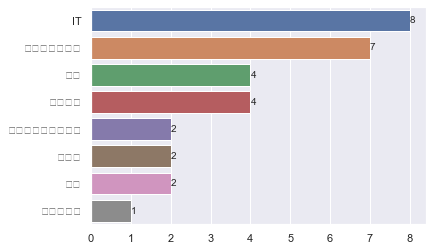

In [53]:
%matplotlib inline

invest_mom_neutral = sector_neutral[sector_neutral['sector_scale_ret'].rank(ascending=False, na_option='bottom') <= 30]

invest_mom_neutral_dist = data_market.set_index('종목코드').loc[invest_mom_neutral.index.tolist(), 'SEC_NM_KOR'].value_counts()

display(invest_mom_neutral_dist)
g = sns.barplot(x=invest_mom_neutral_dist.tolist(), y=invest_mom_neutral_dist.index.tolist())
g.bar_label(g.containers[0])
g

글로벌 투자를 하는 경우에는 지역, 국가, 섹터별로도 중립화된 포트폴리오를 구성하기도 합니다.

# 마법공식 - 조엘 그린블라트

## 밸류 VS 퀄리티

In [55]:
code_template = '{0:06d}'
KOR_ticker = pd.read_csv('data/KOR_ticker.csv', encoding='cp949')
KOR_value = pd.read_csv('data/KOR_value.csv', encoding='cp949')
# 재무정보
with open('data/KOR_fs.json', 'r') as f:
    KOR_fs = json.load(f)
fs_yearly = {}
for year, acc_code_value in KOR_fs.items():
    fs_yearly[year] = pd.concat(
        [pd.DataFrame(code_value.values(), index= code_value.keys(), columns=[account]) for account, code_value in acc_code_value.items()], axis=1)

KOR_ticker['종목코드'] = KOR_ticker['종목코드'].apply(lambda x: code_template.format(x))
KOR_value['종목코드'] = KOR_value['종목코드'].apply(lambda x: code_template.format(x))
KOR_fs = fs_yearly['2021/12']

KOR_value = KOR_value.set_index('종목코드')
KOR_fs


,매출액,매출원가,매출총이익,판매비와관리비,인건비,유무형자산상각비,연구개발비,광고선전비,판매비,관리비,...,파생상품관련손익,외환거래손익,순영업손익,영업손익,당기손익인식금융자산,파생상품자산,*이연대출부대비용,당기손익인식금융부채,파생상품부채,이익잉여금
005930,2796048.0,1664113.0,1131935.0,615596.0,75568.0,20731.0,224017.0,53760.0,131185.0,61926.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373220,178519.0,139531.0,38988.0,31303.0,6672.0,1492.0,1069.0,131.0,16234.0,3810.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000660,429978.0,240456.0,189522.0,65419.0,10108.0,7449.0,35512.0,931.0,1655.0,6967.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207940,15680.0,8416.0,7265.0,1891.0,676.0,88.0,NaN,53.0,49.0,895.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
051910,426547.0,314364.0,112183.0,61928.0,15600.0,4131.0,2552.0,391.0,9649.0,10475.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
082640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
085620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

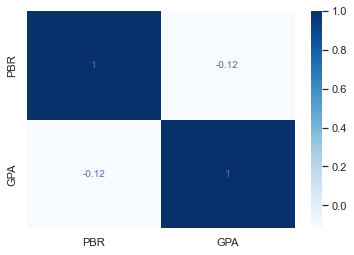

In [59]:
data_pbr = KOR_value['PBR']
data_gpa = KOR_fs['매출총이익'] / KOR_fs['자산']

pbr_gpa = pd.concat([data_pbr, -data_gpa], axis=1)
pbr_gpa.columns = ['PBR', 'GPA']
sns.heatmap(pbr_gpa.corr(method='spearman'), annot=True, annot_kws=dict(color='b'), cmap='Blues')

<AxesSubplot:>

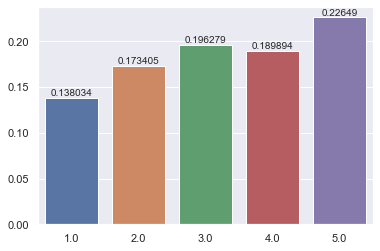

In [73]:
pbr_gpa = pd.concat([data_pbr, data_gpa], axis=1)
pbr_gpa.columns = ['PBR', 'GPA']

def ntile(data, n=5):
    step = 1/n
    data_copy = data.copy()
    # data_market[f'PBR_{n}_tile'] = None
    
    for r in range(n):
        left = data.quantile(r*step)
        right = data.quantile((r+1)*step)

        left_cond = data >= left
        right_cond = data < right if r < n-1 else data <= right

        data_copy[left_cond & right_cond] = r+1
    return data_copy

pbr_gpa['quantile_pbr'] = ntile(data_pbr, 5)
groups = pbr_gpa[pbr_gpa['quantile_pbr'].isna().apply(lambda x: not x)].groupby('quantile_pbr')
g = sns.barplot(x=groups.mean()['GPA'].index.tolist(), y=groups.mean()['GPA'].tolist())
g.bar_label(g.containers[0])
g

PBR이 낮을수록 GPA도 낮으며, 즉 가치주일수록 우량성은 떨어집니다. 반면에 PBR이 높을수록 GPA도 높으며, 이는 주식의 가격이 비쌀수록 우량성도 높다는 뜻입니다.

## 마법공식

1. 이율 : 이자 및 법인세 차감전이익 / 기업가치
2. 투하자본수익률(ROC) : 이자 및 법인세 차감전이익 / 투하자본

In [83]:
code_template = '{0:06d}'

KOR_value = pd.read_csv('data/KOR_value.csv', encoding='cp949')
KOR_ticker = pd.read_csv('data/KOR_ticker.csv', encoding='cp949')

KOR_value['종목코드'] = KOR_value['종목코드'].apply(lambda x : code_template.format(x))
KOR_ticker['종목코드'] = KOR_ticker['종목코드'].apply(lambda x : code_template.format(x))

KOR_value = KOR_value.set_index('종목코드')
KOR_ticker = KOR_ticker.set_index('종목코드')

with open('data/KOR_fs.json', 'r') as f:
    data = json.load(f)
KOR_fs = pd.concat(
    [pd.DataFrame(code_value.values(), index=code_value.keys(), columns=[account])\
        for account, code_value in data['2021/12'].items()],
    axis=1)

display(KOR_ticker.head())
display(KOR_fs.head())
display(KOR_value.head())

,종목명,시장구분,업종명,종가,대비,등락률,시가총액,EPS,PER,선행 EPS,선행 PER,BPS,PBR,주당배당금,배당수익률
종목코드,,,,,,,,,,,,,,,
005930,삼성전자,KOSPI,전기전자,57600,-900,-1.54,343859474880000,5777.0,9.97,7075.0,8.14,43611.0,1.32,1444,2.51
373220,LG에너지솔루션,KOSPI,전기전자,401000,-12000,-2.91,93834000000000,3963.0,101.19,5072.0,79.06,39831.0,10.07,0,0.00
000660,SK하이닉스,KOSPI,전기전자,92200,-3000,-3.15,67121818053000,13989.0,6.59,17396.0,5.30,90394.0,1.02,1540,1.67
207940,삼성바이오로직스,KOSPI,의약품,817000,-4000,-0.49,58149158000000,5879.0,138.97,8156.0,100.17,74551.0,10.96,0,0.00
051910,LG화학,KOSPI,화학,553000,-15000,-2.64,39037565679000,47108.0,11.74,36213.0,15.27,278455.0,1.99,12000,2.17


,매출액,매출원가,매출총이익,판매비와관리비,인건비,유무형자산상각비,연구개발비,광고선전비,판매비,관리비,...,파생상품관련손익,외환거래손익,순영업손익,영업손익,당기손익인식금융자산,파생상품자산,*이연대출부대비용,당기손익인식금융부채,파생상품부채,이익잉여금
005930,2796048.0,1664113.0,1131935.0,615596.0,75568.0,20731.0,224017.0,53760.0,131185.0,61926.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373220,178519.0,139531.0,38988.0,31303.0,6672.0,1492.0,1069.0,131.0,16234.0,3810.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000660,429978.0,240456.0,189522.0,65419.0,10108.0,7449.0,35512.0,931.0,1655.0,6967.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207940,15680.0,8416.0,7265.0,1891.0,676.0,88.0,NaN,53.0,49.0,895.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
051910,426547.0,314364.0,112183.0,61928.0,15600.0,4131.0,2552.0,391.0,9649.0,10475.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,PER,PBR,PCR,PSR
종목코드,,,,
005930,8.944680,1.151274,5.391614,1.255426
373220,121.650473,11.027635,98.516248,5.400434
000660,7.202464,1.112060,3.493364,1.608460
207940,145.747571,11.493708,126.190594,36.585615
051910,10.483630,1.657597,6.982618,0.901960


이익수익률  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;= 이자 및 법인세 차감전이익 / 기업가치  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;= 이자 및 법인세 차감전이익 / (시가총액 + 순차입금)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;= (당기순이익 + 법인세 + 이자비용) / (시가총액 + 총부채 - 여유자금)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;= (당기순이익 + 법인세 + 이자비용) / (시가총액 + 총부채 - (현금 - max(0, 유동부채 - 유동자산 + 현금)) 

In [80]:
# 분자
magic_ebit = KOR_fs[['지배주주순이익', '법인세비용', '이자비용']].sum(axis=1)

# 분모
magic_cap = KOR_value['PER'] * KOR_fs['지배주주순이익']
magic_debt = KOR_fs['부채']
magic_excess_cash_1 = KOR_fs['유동부채'] - KOR_fs['유동자산'] + KOR_fs['현금및현금성자산']
magic_excess_cash_1[magic_excess_cash_1 < 0] = 0
magic_excess_cash2 = KOR_fs['현금및현금성자산'] - magic_excess_cash1

magic_ev = magic_cap + magic_debt - magic_excess_cash_2

# 이익수익률
magic_ev = magic_ebit / magic_ev

,매출액,매출원가,매출총이익,판매비와관리비,인건비,유무형자산상각비,연구개발비,광고선전비,판매비,관리비,...,파생상품관련손익,외환거래손익,순영업손익,영업손익,당기손익인식금융자산,파생상품자산,*이연대출부대비용,당기손익인식금융부채,파생상품부채,이익잉여금
005930,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373220,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000660,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207940,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
051910,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,<built-in method values of dict object at 0x00...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
082640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
085620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
